<a href="https://colab.research.google.com/github/JonathanMartignon/ReconocimientoDePatrones/blob/master/Rayos_X.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://www.kaggle.com/bachrr/covid-chest-xray/data?select=images

https://www.kaggle.com/bachrr/covid-chest-xray/data?select=images



     Debe crear un conjunto de datos que contenga dos carpetas, en las que una muestrea imágenes de rayos X de pacientes normales (que puede obtener de este enlace de Kaggle). He tomado alrededor de 100 imágenes de rayos X muestreadas de pacientes normales.
     Luego, debe crear otra carpeta en la que colocará las imágenes de rayos X de los pacientes con coronavirus. (Para esto tienes que hacer algunas cosas de análisis de datos).
     Después de crear dos carpetas, fusionaremos las imágenes y estableceremos las etiquetas
     Luego lo dividiremos en un conjunto de entrenamiento y prueba y crearemos un modelo VGG que predecirá nuestros datos.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import shutil
import cv2
# paths from imutils atraviesa un directorio y nos permite enumerar todas las imagenes en un directorio.
from imutils import paths
import matplotlib.pyplot as plt
import os
import skimage
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from scipy import ndimage
from skimage.segmentation import slic
from skimage.feature import greycomatrix, greycoprops 


In [0]:
metadatos = pd.read_csv('drive/My Drive/metadatos.csv')
metadatos.head()

,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,in_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 28
0,2,0.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [0]:
metadatos.shape

(372, 29)

In [0]:
metadatos.columns

Index(['patientid', 'offset', 'sex', 'age', 'finding', 'survival', 'intubated',
       'intubation_present', 'went_icu', 'in_icu', 'needed_supplemental_O2',
       'extubated', 'temperature', 'pO2_saturation', 'leukocyte_count',
       'neutrophil_count', 'lymphocyte_count', 'view', 'modality', 'date',
       'location', 'folder', 'filename', 'doi', 'url', 'license',
       'clinical_notes', 'other_notes', 'Unnamed: 28'],
      dtype='object')

In [0]:
# Eliminamos las columnas con nan's

In [0]:
metadatos.dropna(axis=1,inplace=True)

In [0]:
metadatos.groupby('finding').count()

,patientid,view,modality,folder,filename,url
finding,,,,,,
ARDS,4,4,4,4,4,4
COVID-19,296,296,296,296,296,296
"COVID-19, ARDS",12,12,12,12,12,12
Chlamydophila,2,2,2,2,2,2
E.Coli,4,4,4,4,4,4
Klebsiella,1,1,1,1,1,1
Legionella,2,2,2,2,2,2
No Finding,3,3,3,3,3,3
Pneumocystis,15,15,15,15,15,15


In [0]:
# Extraemos las imágenes de rayos X que resultaron positivas para COVID-19

# En este paso extraeremos las radiografías de los pacientes con COVID-19. para eso, cambiaremos 
# el conjunto de datos y contaremos las filas donde el resultado es igual a COVID-19, y la vista 
# debe ser PA (Posterioranterior).

In [0]:
"""
# Seleccionaremos de todas las combinaciones de pacientes 'COVID-19' con vista de rayos X 'PA'
coronavirus = "COVID-19" # Virus que nos interesa buscar en el set de imágenes
x_ray = "PA" # Vista de los Rayos-X

ruta_img = "drive/My Drive/RP_Proy_Img" # Ruta de la carpeta que contiene las imagenes
ruta_img_salida = 'drive/My Drive/Datos/COVID_19' # Carpeta de salida en la que guardaremos las imágenes

# bucle sobre las filas del marco de datos COVID-19
for (i, row) in metadatos.iterrows():
    if row["finding"] != coronavirus or row["view"] != x_ray:
        continue

    filename = row['filename'].split(os.path.sep)[-1]
    filePath = os.path.sep.join([ruta_img, filename])
    shutil.copy2(filePath, ruta_img_salida)
print('Listo! Se ha hecho la descarga')
"""

'\n# Seleccionaremos de todas las combinaciones de pacientes \'COVID-19\' con vista de rayos X \'PA\'\ncoronavirus = "COVID-19" # Virus que nos interesa buscar en el set de imágenes\nx_ray = "PA" # Vista de los Rayos-X\n\nruta_img = "drive/My Drive/RP_Proy_Img" # Ruta de la carpeta que contiene las imagenes\nruta_img_salida = \'drive/My Drive/Datos/COVID_19\' # Carpeta de salida en la que guardaremos las imágenes\n\n# bucle sobre las filas del marco de datos COVID-19\nfor (i, row) in metadatos.iterrows():\n    if row["finding"] != coronavirus or row["view"] != x_ray:\n        continue\n\n    filename = row[\'filename\'].split(os.path.sep)[-1]\n    filePath = os.path.sep.join([ruta_img, filename])\n    shutil.copy2(filePath, ruta_img_salida)\nprint(\'Listo! Se ha hecho la descarga\')\n'

Después de obtener todas las imágenes de rayos X de COVID-19, dla colocamos en otra carpeta. Se tomaron 141 imágenes de rayos X de COVID-19 para el modelo que vamos a presentar.

https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [0]:
dataset = "drive/My Drive/Datos" # El dataset
args={}
args["dataset"]=dataset

In [0]:
def mean_image(image,label):
    im_rp = image.reshape((image.shape[0]*image.shape[1],image.shape[2]))
    sli_1d = np.reshape(label,-1)    
    uni = np.unique(sli_1d)
    uu = np.zeros(im_rp.shape)
    for i in uni:
        loc=np.where(sli_1d==i)[0]
        #print(loc)
        mm=np.mean(im_rp[loc,:],axis=0)
        uu[loc,:]=mm
    img_superpixel = np.reshape(uu,[image.shape[0],image.shape[1],image.shape[2]]).astype('uint8')
    return img_superpixel

In [0]:
# colocamos las etiquetas a las imagenes

# iPath contiene la ruta de todas las imagenes
iPaths = list(paths.list_images(args["dataset"])) 
# lista que contendra todas las imagenes, tanto las de covid como las normales
data = []
# lista que contendra todas las etiquetas de las imagenes, es decir, 
# indica si la imagen es una de covid o si es de una normal
labels = []
for iPath in iPaths:
    # dividimos la ruta de las imagenes, para que ellas que tienen un torax 'Normal' 
    # y para las que tienen un torax con COVID-19
    label = iPath.split(os.path.sep)[-2]   
    # Leemos cada imagen de la ruta de imagenes
    image = cv2.imread(iPath)
    # Convertimos las imagenes a RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    # Redimensionamos las imagenes
    image = cv2.resize(image, (224, 224))
    #image = ndimage.gaussian_filter(image, 3)
    #segmentos_slic = slic(image, n_segments=400, compactness=10, sigma=1, convert2lab=True)
    #image = mean_image(image,segmentos_slic)
    
    data.append(image)
    labels.append(label)
#  escalamos las intensidades de pixeles de cada imagen al rango [0,1], 
# y convertimos ambas listas como un arreglo de NumPy
data = np.array(data) / 255.0
labels = np.array(labels)


#### Filtro Gaussiano y Superpixeles


In [0]:
gausian_data = []
for i in range(len(data)):
  image = ndimage.gaussian_filter(data[i]*255, 3)
  segmentos_slic = slic(image, n_segments=400, compactness=10, sigma=1, convert2lab=True)
  image = mean_image(image,segmentos_slic)
  gausian_data.append(image)
gausian_data = np.array(gausian_data) / 255.0

In [0]:
len(data)

241

In [0]:
# obtenemos el nombre de las imagenes de cada carpeta, por eso indicamos la ruta en
# la que se encuentran las dos carpetas (Una es la de las imagenes con covid y 
# la otra es con pacientes normales)
Cimages = os.listdir("drive/My Drive/Datos/COVID_19")
Nimages = os.listdir("drive/My Drive/Datos/Normal")


Radiografía de tórax Normal (sano) VS radiografía de tórax con COVID-19


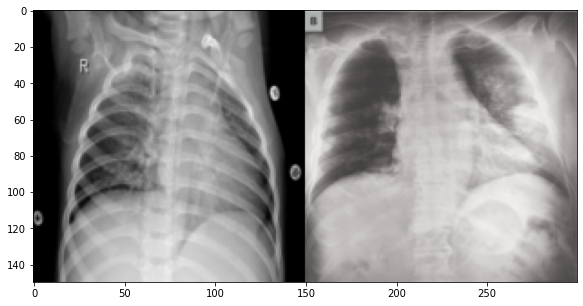

Radiografía de tórax Normal (sano) VS radiografía de tórax con COVID-19


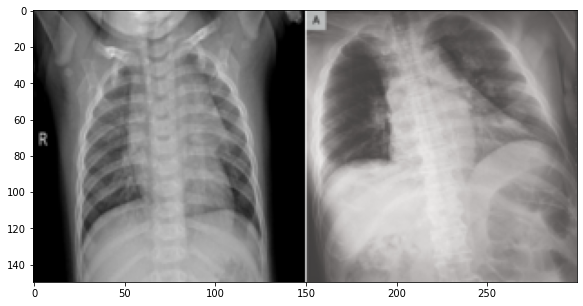

Radiografía de tórax Normal (sano) VS radiografía de tórax con COVID-19


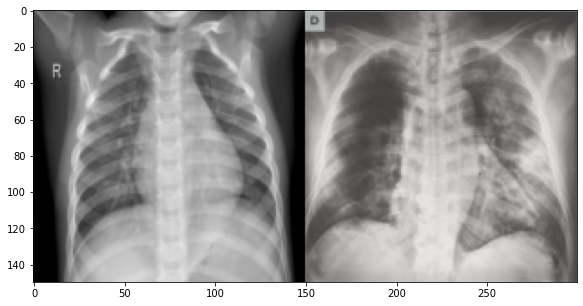

Radiografía de tórax Normal (sano) VS radiografía de tórax con COVID-19


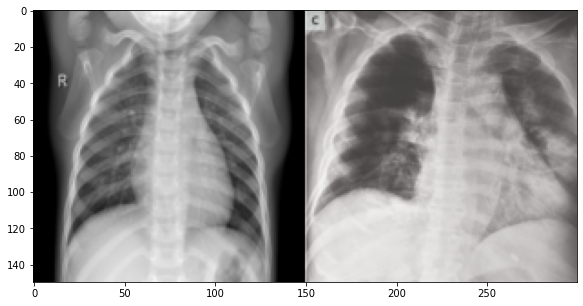

Radiografía de tórax Normal (sano) VS radiografía de tórax con COVID-19


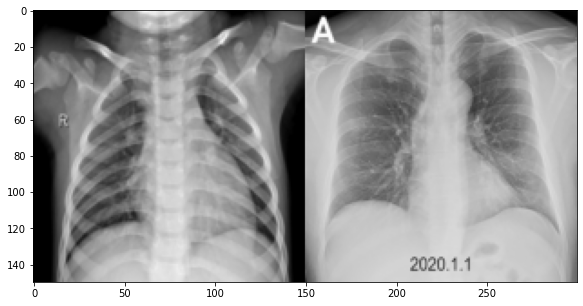

In [0]:

def grafica(ruta,Cimages,Nimages,i):
  """Funcion que muestra un par de imagenes, la de la izquiera contiene una de un torax normal (sano),
  mientras que la de la derecha contiene una de un torax con COVID-19.
  Parametros:
    ruta(string): Ruta de la carpeta que contiene a las dos carpetas: Normal y COVID_19.
    Cimages(list): Nombre de las imagenes de la carpeta COVID_19.
    Nimages(list): Nombre de las imagenes de la carpeta Normal.
    i(int): Indice de la figura que se quiere mostrar
    """
  
  # leemos la imagen normal que tiene el indice i
  normal = cv2.imread(ruta+"Normal/"+Nimages[i])
  # Cambiamos el tamaño de la imagen para que coincida con un cierto tamaño.
  normal = skimage.transform.resize(normal, (150, 150, 3))
  # leemos la imagen con covid 19 que tiene el indice i
  covid = cv2.imread(ruta+"COVID_19/"+Cimages[i])
  # Cambiamos el tamaño de la imagen para que coincida con un cierto tamaño.
  covid = skimage.transform.resize(covid, (150, 150, 3) , mode = 'reflect')
  # concatenamos las imagenes anteriores
  parejas = np.concatenate((normal, covid), axis=1)
  print("Radiografía de tórax Normal (sano) VS radiografía de tórax con COVID-19")
  plt.figure(figsize=(10,5))
  plt.imshow(parejas)
  plt.show()

for i in range(0,5):
    grafica("drive/My Drive/Datos/",Cimages,Nimages,i)

In [0]:
# categorizamos numericamente cada etiqueta

etiquetas = []

for i in range(len(labels)):
  if labels[i] == 'COVID_19':
    etiquetas.append(1)
  else:
    etiquetas.append(0)

In [0]:
etiquetas = np.array(etiquetas)

#### Dividiendo nuestro conjunto de datos, Imágenes normales e Imágenes con filtro gaussiano

In [0]:
# Dividimos nuestro conjunto de datos en conjuntos de entrenamiento y pruebas; donde el conjunto 
# de entrenamiento contiene el 80% de los datos, mientras que el de prueba contiene el 20%.
(X_train, X_test, Y_train, Y_test) = train_test_split(data, etiquetas, random_state=42)



In [0]:
(X_train_g, X_test_g, Y_train_g, Y_test_g) = train_test_split(gausian_data, etiquetas, random_state=42)

In [0]:
# dimensiones de las imagenes de entrenamiento y prueba
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((180, 224, 224, 3), (61, 224, 224, 3), (180,), (61,))

In [0]:
X_train_g.shape,X_test_g.shape,Y_train_g.shape,Y_test_g.shape

((180, 224, 224, 3), (61, 224, 224, 3), (180,), (61,))

Podemos ver que tenemos 192 imágenes para entrenamiento y 49 imágenes para prueba.

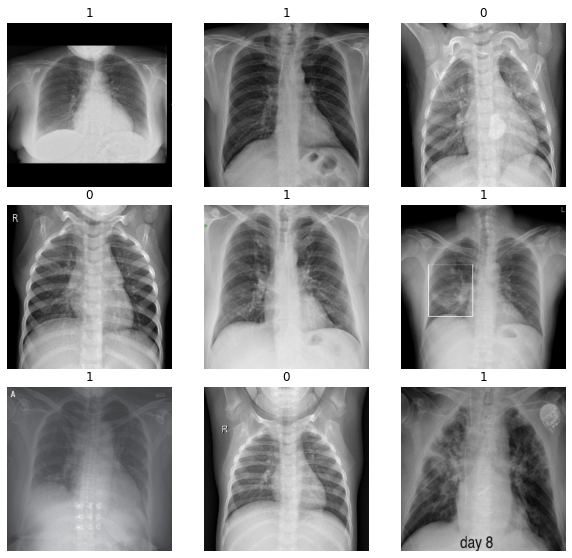

In [0]:
fig, axes = plt.subplots(3, 3, figsize = (10, 10))
axes = axes.ravel()
n_training = len(X_train)
print('--- Imágenes Normales:\n')
for i in np.arange(0, 9):
    # Seleccionamos un indice aleatoriamente
    indice = np.random.randint(0, n_training) 
    axes[i].imshow(X_train[indice])
    axes[i].set_title(Y_train[indice])
    axes[i].axis('off')
    
plt.subplots_adjust(hspace = 0.01)

Imágenes con filtro gaussiano y Superpixeles:



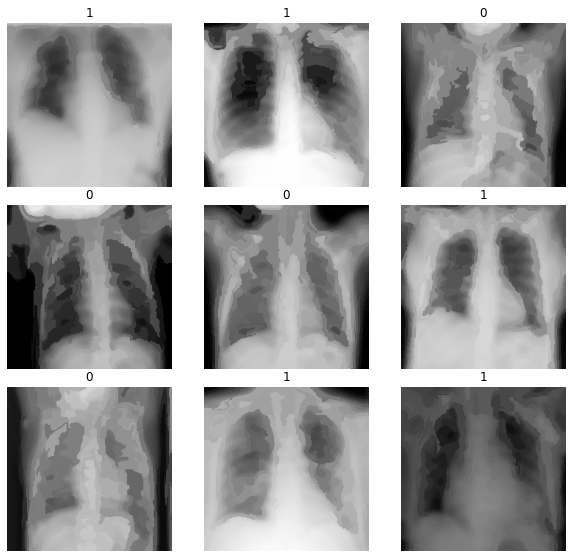

In [0]:
fig, axes = plt.subplots(3, 3, figsize = (10, 10))
axes = axes.ravel()
n_training = len(X_train_g)
print('Imágenes con filtro gaussiano y Superpixeles:\n')
for i in np.arange(0, 9):
    indice = np.random.randint(0, n_training) 
    axes[i].imshow(X_train_g[indice])
    axes[i].set_title(Y_train_g[indice])
    axes[i].axis('off')
    
plt.subplots_adjust(hspace = 0.01)

In [0]:
x_train = np.reshape(X_train, (180, X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))
x_test = np.reshape(X_test, (61,X_test.shape[1]*X_test.shape[1]*X_test.shape[3]))

In [0]:
x_train_g = np.reshape(X_train_g, (180, X_train_g.shape[1]*X_train_g.shape[2]*X_train_g.shape[3]))
x_test_g = np.reshape(X_test_g, (61,X_test_g.shape[1]*X_test_g.shape[1]*X_test_g.shape[3]))

In [0]:
#X = np.array([[0], [1], [2], [3]])
#y = np.array([0, 0, 1, 1])
#X.shape,y.shape

## KNN

In [0]:

# Creamos el clasificador KNN con 100 vecinos
knn = KNeighborsClassifier(n_neighbors = 100)
# Ajustamos el clasificador a los datos
Y_pred = knn.fit(x_train,Y_train).predict(x_test)

In [0]:
Y_pred_g = knn.fit(x_train_g,Y_train_g).predict(x_test_g)

In [0]:
reporte = classification_report(Y_test, Y_pred)
print('--- Imágenes Normales:\n')
print(reporte)
reporte = classification_report(Y_test_g, Y_pred_g)
print('\n\n--- Imágenes con filtro Gaussiano y Superpixeles:\n')
print(reporte)

--- Imágenes Normales:

              precision    recall  f1-score   support

           0       0.82      0.96      0.88        24
           1       0.97      0.86      0.91        37

    accuracy                           0.90        61
   macro avg       0.90      0.91      0.90        61
weighted avg       0.91      0.90      0.90        61



--- Imágenes con filtro Gaussiano y Superpixeles:

              precision    recall  f1-score   support

           0       0.77      0.96      0.85        24
           1       0.97      0.81      0.88        37

    accuracy                           0.87        61
   macro avg       0.87      0.88      0.87        61
weighted avg       0.89      0.87      0.87        61



--- Imágenes normales:



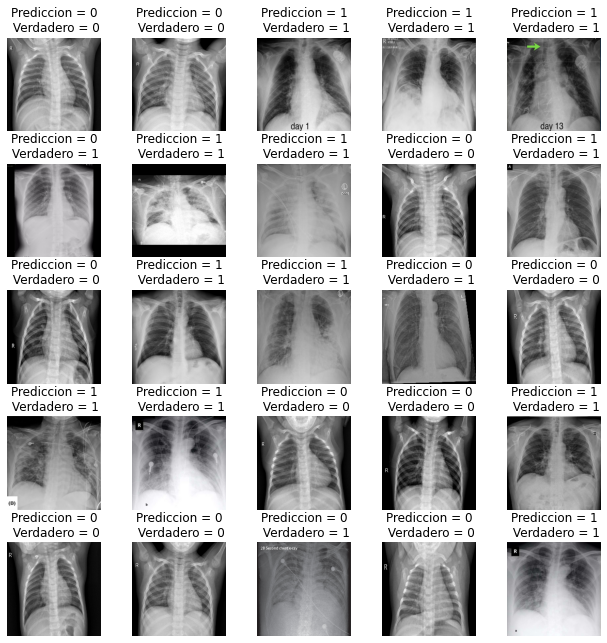

In [0]:
# Predecimos el conjunto de prueba y los compararmos con los datos de prueba.

fig, axes = plt.subplots(5, 5, figsize = (11, 11))
axes = axes.ravel()
y_pred = knn.predict(x_test)
print('--- Imágenes normales:\n')
for i in np.arange(0,5*5):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Prediccion = {}\n Verdadero = {}'.format(y_pred[i], Y_test[i]))
    axes[i].axis('off')
plt.subplots_adjust(wspace = 0.1, hspace=0.35)

--- Imágenes con filtro Gaussiano y Superpixeles:



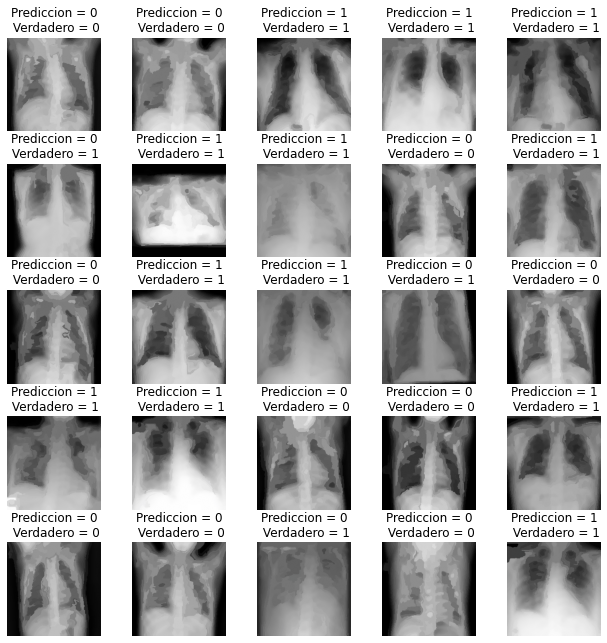

In [0]:
fig, axes = plt.subplots(5, 5, figsize = (11, 11))
axes = axes.ravel()
y_pred_g = knn.predict(x_test_g)
print('--- Imágenes con filtro Gaussiano y Superpixeles:\n')
for i in np.arange(0,5*5):
    axes[i].imshow(X_test_g[i])
    axes[i].set_title('Prediccion = {}\n Verdadero = {}'.format(y_pred_g[i], Y_test_g[i]))
    axes[i].axis('off')
plt.subplots_adjust(wspace = 0.1, hspace=0.35)

## Naive Bayes



### Bernoulli

In [0]:
# Ajustamos el clasificador a los datos
# Creamos otroclasificador_ Naive Bayes Bernoulli
nbb = BernoulliNB()

Y_pred5 = nbb.fit(x_train,Y_train).predict(x_test)
Y_pred5_g = nbb.fit(x_train_g,Y_train_g).predict(x_test_g)
#Generamos el reporte del modelo con escala de grises
reporte5 = classification_report(Y_test, Y_pred5)
print('--- Imágenes Normales:\n')
print(reporte5)

reporte5 = classification_report(Y_test_g, Y_pred5_g)
print('--- Imágenes con filtro Gaussiano y SuperPixeles:\n')
print(reporte5)

--- Imágenes Normales:

              precision    recall  f1-score   support

           0       0.78      0.58      0.67        24
           1       0.77      0.89      0.82        37

    accuracy                           0.77        61
   macro avg       0.77      0.74      0.75        61
weighted avg       0.77      0.77      0.76        61

--- Imágenes con filtro Gaussiano y SuperPixeles:

              precision    recall  f1-score   support

           0       0.76      0.54      0.63        24
           1       0.75      0.89      0.81        37

    accuracy                           0.75        61
   macro avg       0.76      0.72      0.72        61
weighted avg       0.76      0.75      0.74        61




 Imágenes normales: 



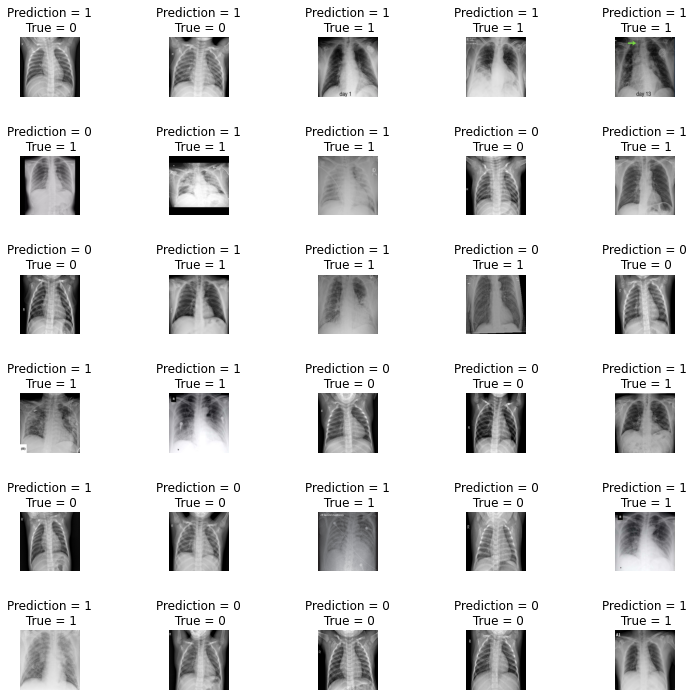

In [0]:
# Predecimos el conjunto de prueba y los compararmos con los datos de prueba.

fig, axes = plt.subplots(6, 5, figsize = (12, 12))
axes = axes.ravel()
y_pred5 = nbb.predict(x_test)
print('\n Imágenes normales: \n')
for i in np.arange(0,6*5):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Prediction = {}\n True = {}'.format(y_pred5[i], Y_test[i]))
    axes[i].axis('off')
plt.subplots_adjust(wspace = 1, hspace=1)


 Imágenes con filtro Gaussiano y Superpixeles:



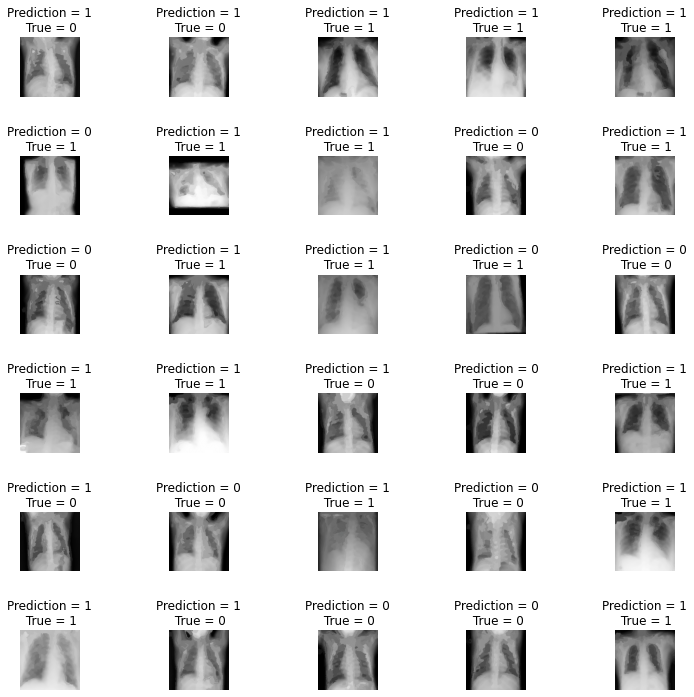

In [0]:

fig, axes = plt.subplots(6, 5, figsize = (12, 12))
axes = axes.ravel()
y_pred5_g = nbb.predict(x_test_g)
print('\n Imágenes con filtro Gaussiano y Superpixeles:\n')
for i in np.arange(0,6*5):
    axes[i].imshow(X_test_g[i])
    axes[i].set_title('Prediction = {}\n True = {}'.format(y_pred5_g[i], Y_test_g[i]))
    axes[i].axis('off')
plt.subplots_adjust(wspace = 1, hspace=1)

### Multinomial

In [0]:
# Ajustamos el clasificador a los datos
# Creamos otroclasificador_ Naive Bayes Multinomial
nbm = MultinomialNB()

Y_pred2 = nbm.fit(x_train,Y_train).predict(x_test)
Y_pred2_g = nbm.fit(x_train_g,Y_train_g).predict(x_test_g)
#Generamos el reporte del modelo con escala de grises
reporte2 = classification_report(Y_test, Y_pred2)
print('--- Imágenes Normales:\n')
print(reporte2)
reporte2_g = classification_report(Y_test_g, Y_pred2_g)
print('--- Imágenes con filtro Gaussiano y Superpixeles:\n')
print(reporte2_g)

--- Imágenes Normales:

              precision    recall  f1-score   support

           0       0.85      0.96      0.90        24
           1       0.97      0.89      0.93        37

    accuracy                           0.92        61
   macro avg       0.91      0.93      0.92        61
weighted avg       0.92      0.92      0.92        61

--- Imágenes con filtro Gaussiano y Superpixeles:

              precision    recall  f1-score   support

           0       0.85      0.96      0.90        24
           1       0.97      0.89      0.93        37

    accuracy                           0.92        61
   macro avg       0.91      0.93      0.92        61
weighted avg       0.92      0.92      0.92        61



Imágenes Normales:



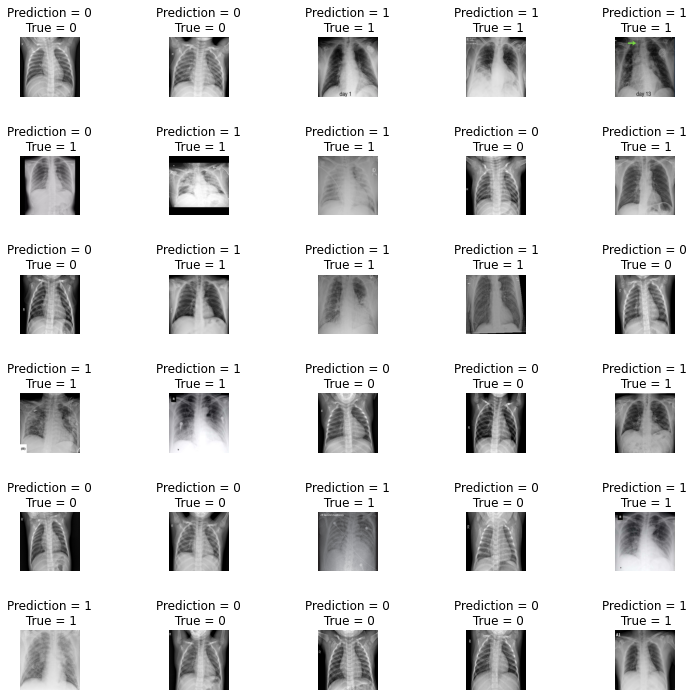

In [0]:
# Predecimos el conjunto de prueba y los compararmos con los datos de prueba.

fig, axes = plt.subplots(6, 5, figsize = (12, 12))
axes = axes.ravel()
y_pred2 = nbm.predict(x_test)
print('Imágenes Normales:\n')
for i in np.arange(0,6*5):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Prediction = {}\n True = {}'.format(y_pred2[i], Y_test[i]))
    axes[i].axis('off')
plt.subplots_adjust(wspace = 1, hspace=1)

Imágenes con Filtro Gaussiano y Superpixeles:



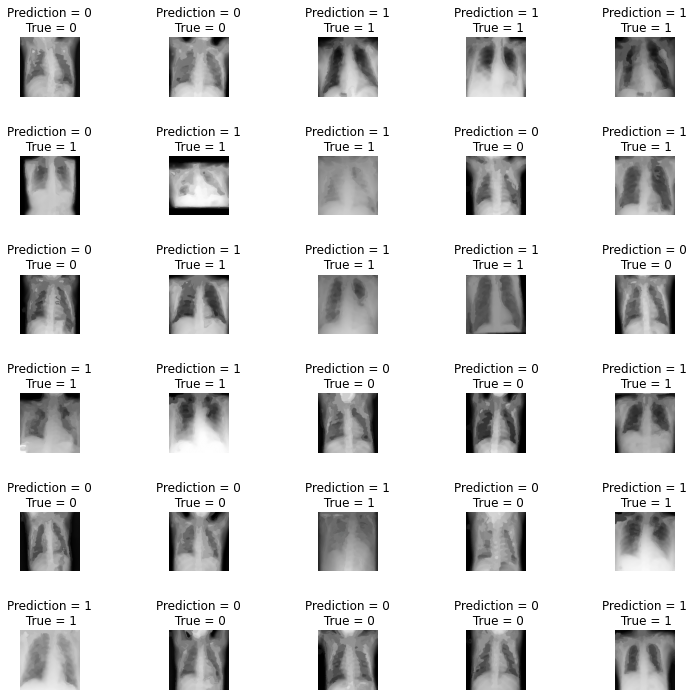

In [0]:

fig, axes = plt.subplots(6, 5, figsize = (12, 12))
axes = axes.ravel()
y_pred2_g = nbm.predict(x_test_g)
print('Imágenes con Filtro Gaussiano y Superpixeles:\n')
for i in np.arange(0,6*5):
    axes[i].imshow(X_test_g[i])
    axes[i].set_title('Prediction = {}\n True = {}'.format(y_pred2_g[i], Y_test_g[i]))
    axes[i].axis('off')
plt.subplots_adjust(wspace = 1, hspace=1)

### Gauss

In [0]:

# Creamos otroclasificador_ Naive Bayes Gauss
nbg = GaussianNB()

Y_pred3 = nbg.fit(x_train,Y_train).predict(x_test)
Y_pred3_g = nbg.fit(x_train_g,Y_train_g).predict(x_test_g)

#Generamos el reporte del modelo con escala de grisesEsto es con KNN, aquí tiene menos problemas con los derrames, en apariencia sí los detecta, el problema es la consolidación porque abarca no solo el pulmón internamente, sino que también externo
reporte3 = classification_report(Y_test, Y_pred3)
print('--- Imágenes Normales: \n')
print(reporte3)
reporte3_g = classification_report(Y_test_g, Y_pred3_g)
print('--- Imágenes con Filtro Gaussiano y Superpixeles: \n')
print(reporte3)

--- Imágenes Normales: 

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        24
           1       0.97      0.97      0.97        37

    accuracy                           0.97        61
   macro avg       0.97      0.97      0.97        61
weighted avg       0.97      0.97      0.97        61

--- Imágenes con Filtro Gaussiano y Superpixeles: 

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        24
           1       0.97      0.97      0.97        37

    accuracy                           0.97        61
   macro avg       0.97      0.97      0.97        61
weighted avg       0.97      0.97      0.97        61



Imágenes Normales:



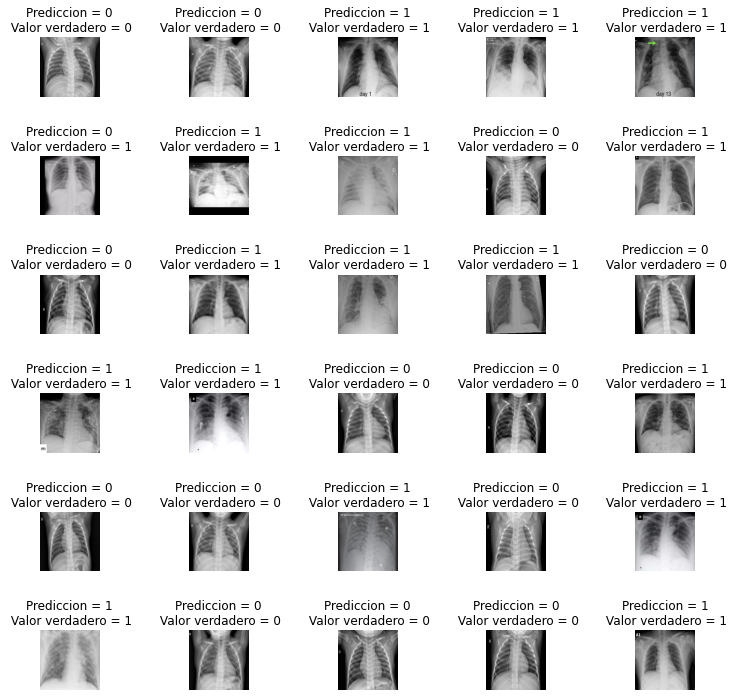

In [0]:
# Predecimos el conjunto de prueba y los compararmos con los datos de prueba.

fig, axes = plt.subplots(6, 5, figsize = (12, 12))
axes = axes.ravel()
y_pred3 = nbg.predict(x_test)
print('Imágenes Normales:\n')
for i in np.arange(0,6*5):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Prediccion = {}\n Valor verdadero = {}'.format(y_pred3[i], Y_test[i]))
    axes[i].axis('off')
plt.subplots_adjust(wspace = 1, hspace=1)

Imágenes con Filtro Gaussiano y Superpixeles:



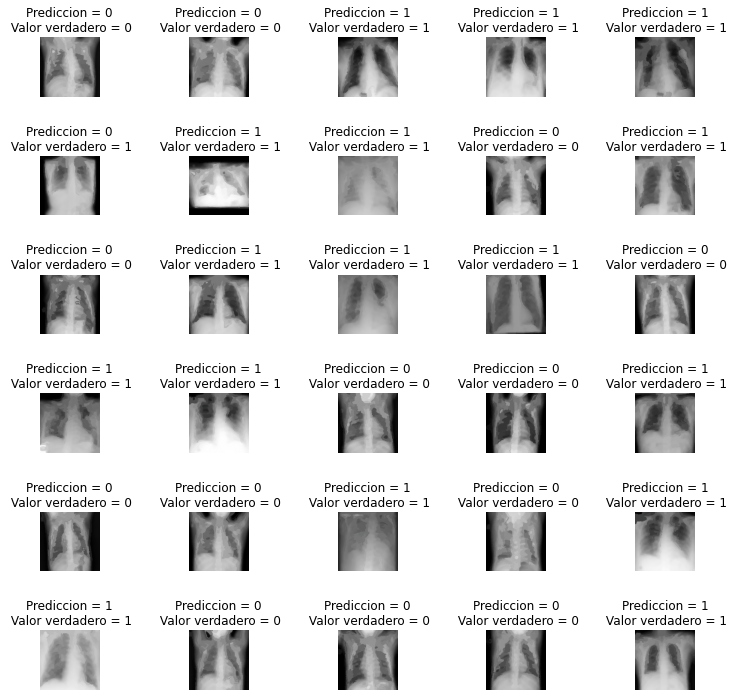

In [0]:
fig, axes = plt.subplots(6, 5, figsize = (12, 12))
axes = axes.ravel()
y_pred3_g = nbg.predict(x_test_g)
print('Imágenes con Filtro Gaussiano y Superpixeles:\n')
for i in np.arange(0,6*5):
    axes[i].imshow(X_test_g[i])
    axes[i].set_title('Prediccion = {}\n Valor verdadero = {}'.format(y_pred3_g[i], Y_test_g[i]))
    axes[i].axis('off')
plt.subplots_adjust(wspace = 1, hspace=1)

## SVM

In [0]:

# Creamos otroclasificador SVM
svm = SVC()

Y_pred4 = svm.fit(x_train,Y_train).predict(x_test)
Y_pred4_g = svm.fit(x_train_g,Y_train_g).predict(x_test_g)

#Generamos el reporte del modelo con escala de grises
reporte4 = classification_report(Y_test, Y_pred4)
print('--- Imágenes Normales:\n')
print(reporte4)
print('\n--- Imágenes con Filtro Gaussiano y Superpixeles\n')
reporte4_g = classification_report(Y_test_g, Y_pred4_g)
print(reporte4_g)

--- Imágenes Normales:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        24
           1       0.97      0.97      0.97        37

    accuracy                           0.97        61
   macro avg       0.97      0.97      0.97        61
weighted avg       0.97      0.97      0.97        61


--- Imágenes con Filtro Gaussiano y Superpixeles

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        24
           1       0.97      0.97      0.97        37

    accuracy                           0.97        61
   macro avg       0.97      0.97      0.97        61
weighted avg       0.97      0.97      0.97        61



## Predicciones

KNN

Imagen Normal


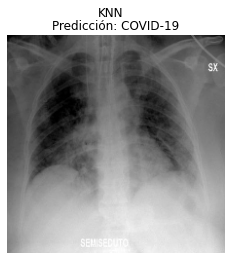

In [0]:
img = cv2.imread('drive/My Drive/covid-19-caso-85-5-4.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
# Redimensionamos la imagen
img = cv2.resize(img, (224, 224))
img = img/ 255.0
img_reshape =  np.reshape(img, (1, img.shape[0]*img.shape[1]*img.shape[2]))
clase_knn = knn.predict(img_reshape)
print('Imagen Normal')
if clase_knn==[0]:
  plt.title('Predicción: Normal')
else:
  plt.title('Predicción: COVID-19')
plt.suptitle('KNN')
plt.imshow(img)
plt.axis('off')
plt.show()

Imagen con Filtro gaussiano y superpixeles


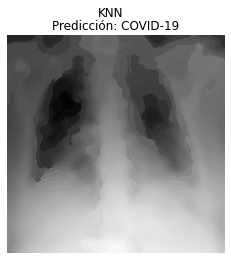

In [0]:
image = ndimage.gaussian_filter(img*255, 3)
segmentos_slic = slic(image, n_segments=400, compactness=10, sigma=1, convert2lab=True)
image = mean_image(image,segmentos_slic)
image = np.array(image) / 255.0
image_reshape =  np.reshape(image, (1, image.shape[0]*image.shape[1]*image.shape[2]))
clase_knn = knn.predict(image_reshape)
print('Imagen con Filtro gaussiano y superpixeles')
if clase_knn==[0]:
  plt.title('Predicción: Normal')
else:
  plt.title('Predicción: COVID-19')
plt.suptitle('KNN')
plt.imshow(image)
plt.axis('off')
plt.show()

Naive Bayes Bernoulli

Imagen Normal


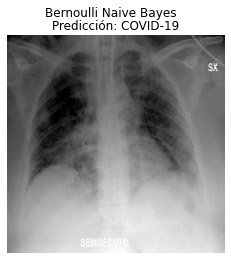

In [0]:
clase_nbb = nbb.predict(img_reshape)
print('Imagen Normal')
if clase_nbb==[0]:
  plt.title('Predicción: Normal')
else:
  plt.title('Predicción: COVID-19')
plt.suptitle('Bernoulli Naive Bayes')
plt.imshow(img)
plt.axis('off')
plt.show()

Imagen con filtro gaussiano y superpixeles


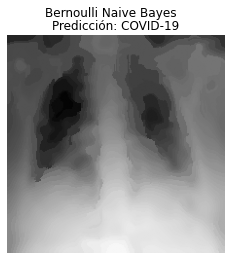

In [0]:
clase_nbb = nbb.predict(image_reshape)
print('Imagen con filtro gaussiano y superpixeles')
if clase_nbb==[0]:
  plt.title('Predicción: Normal')
else:
  plt.title('Predicción: COVID-19')
plt.suptitle('Bernoulli Naive Bayes')
plt.imshow(image)
plt.axis('off')
plt.show()

Naive Bayes Multinomial

Imagen Normal


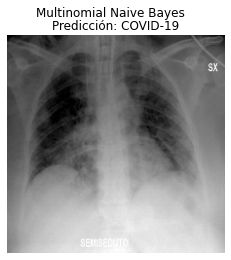

In [0]:
clase_nbm = nbm.predict(img_reshape)
print('Imagen Normal')
if clase_nbm==[0]:
  plt.title('Predicción: Normal')
else:
  plt.title('Predicción: COVID-19')
plt.suptitle('Multinomial Naive Bayes')
plt.imshow(img)
plt.axis('off')
plt.show()

Imagen con filtro gaussiano y superpixeles


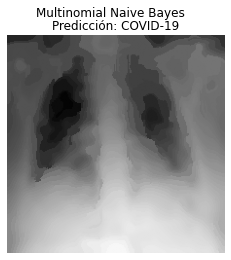

In [0]:
clase_nbm = nbm.predict(image_reshape)
print('Imagen con filtro gaussiano y superpixeles')
if clase_nbm==[0]:
  plt.title('Predicción: Normal')
else:
  plt.title('Predicción: COVID-19')
plt.suptitle('Multinomial Naive Bayes')
plt.imshow(image)
plt.axis('off')
plt.show()

Naive Bayes Gaussiano

Imagen Normal


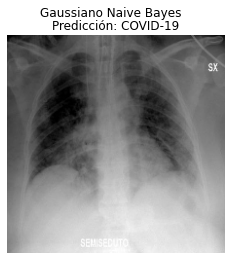

In [0]:
clase_nbg = nbg.predict(img_reshape)
print('Imagen Normal')
if clase_nbg==[0]:
  plt.title('Predicción: Normal')
else:
  plt.title('Predicción: COVID-19')
plt.suptitle('Gaussiano Naive Bayes')
plt.imshow(img)
plt.axis('off')
plt.show()

Imagen con filtro gaussiano y superpixeles


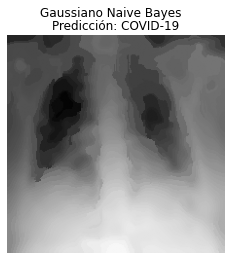

In [0]:
clase_nbg = nbg.predict(image_reshape)
print('Imagen con filtro gaussiano y superpixeles')
if clase_nbg==[0]:
  plt.title('Predicción: Normal')
else:
  plt.title('Predicción: COVID-19')
plt.suptitle('Gaussiano Naive Bayes')
plt.imshow(image)
plt.axis('off')
plt.show()

Maquina de Soporte Vectorial

Imagen Normal


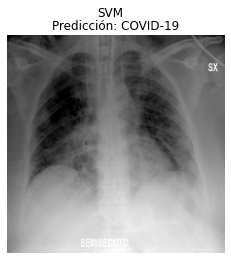

In [0]:
clase_svm = svm.predict(img_reshape)
print('Imagen Normal')
if clase_svm==[0]:
  plt.title('Predicción: Normal')
else:
  plt.title('Predicción: COVID-19')
plt.suptitle('SVM')
plt.imshow(img)
plt.axis('off')
plt.show()

Imagen con filtro gaussiano y superpixeles


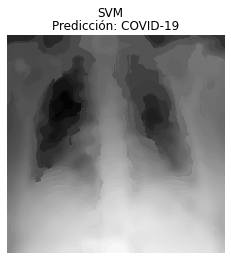

In [0]:
clase_svm = svm.predict(image_reshape)
print('Imagen con filtro gaussiano y superpixeles')
if clase_svm==[0]:
  plt.title('Predicción: Normal')
else:
  plt.title('Predicción: COVID-19')
plt.suptitle('SVM')
plt.imshow(image)
plt.axis('off')
plt.show()

KNN

Imagen Normal


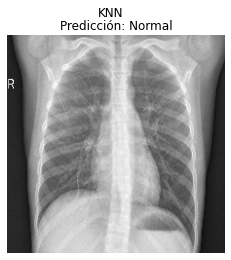

In [0]:
img2 = cv2.imread('drive/My Drive/chest_xray_test_NORMAL_IM-0003-0001.jpeg') #insert a random normal x-ray image
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) 
# Redimensionamos la imagen
img2 = cv2.resize(img2, (224, 224))
img2 = img2/ 255.0
img2_reshape =  np.reshape(img2, (1, img2.shape[0]*img2.shape[1]*img2.shape[2]))
clase2_knn = knn.predict(img2_reshape)
print('Imagen Normal')
if clase2_knn==[0]:
  plt.title('Predicción: Normal')
else:
  plt.title('Predicción: COVID-19')
plt.suptitle('KNN')
plt.imshow(img2)
plt.axis('off')
plt.show()

Imagen con filtro gaussiano y superpixeles


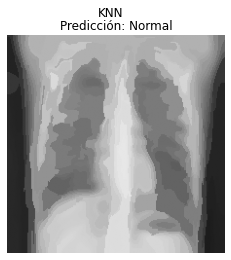

In [0]:
image2 = ndimage.gaussian_filter(img2*255, 3)
segmentos_slic = slic(image2, n_segments=400, compactness=10, sigma=1, convert2lab=True)
image2 = mean_image(image2,segmentos_slic)
image2 = np.array(image2) / 255.0
image2_reshape =  np.reshape(image2, (1, image2.shape[0]*image2.shape[1]*image2.shape[2]))
clase2_knn = knn.predict(image2_reshape)
print('Imagen con filtro gaussiano y superpixeles')
if clase2_knn==[0]:
  plt.title('Predicción: Normal')
else:
  plt.title('Predicción: COVID-19')
plt.suptitle('KNN')
plt.imshow(image2)
plt.axis('off')
plt.show()

Naive Bayes Bernoulli

Imagen Normal


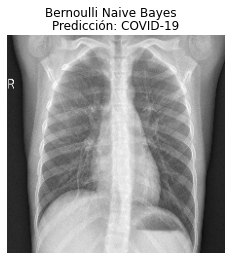

In [0]:
clase2_nbb = nbb.predict(img2_reshape)
print('Imagen Normal')
if clase2_nbb==[0]:
  plt.title('Predicción: Normal')
else:
  plt.title('Predicción: COVID-19')
plt.suptitle('Bernoulli Naive Bayes')
plt.imshow(img2)
plt.axis('off')
plt.show()

Imagen con filtro gaussiano y superpixeles


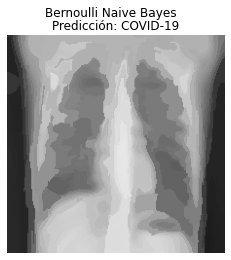

In [0]:
clase2_nbb = nbb.predict(image2_reshape)
print('Imagen con filtro gaussiano y superpixeles')
if clase2_nbb==[0]:
  plt.title('Predicción: Normal')
else:
  plt.title('Predicción: COVID-19')
plt.suptitle('Bernoulli Naive Bayes')
plt.imshow(image2)
plt.axis('off')
plt.show()

Naive Bayes Multinomial

Imagen Normal


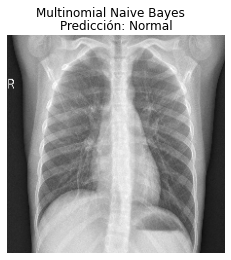

In [0]:
clase2_nbm = nbm.predict(img2_reshape)
print('Imagen Normal')
if clase2_nbm==[0]:
  plt.title('Predicción: Normal')
else:
  plt.title('Predicción: COVID-19')
plt.suptitle('Multinomial Naive Bayes')
plt.imshow(img2)
plt.axis('off')
plt.show()

Imagen con filtro gaussiano y superpixeles


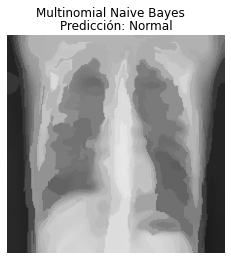

In [0]:
clase2_nbm = nbm.predict(image2_reshape)
print('Imagen con filtro gaussiano y superpixeles')
if clase2_nbm==[0]:
  plt.title('Predicción: Normal')
else:
  plt.title('Predicción: COVID-19')
plt.suptitle('Multinomial Naive Bayes')
plt.imshow(image2)
plt.axis('off')
plt.show()

Naive Bayes Gaussian

Imagen Normal


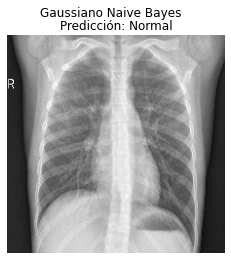

In [0]:
clase2_nbg = nbg.predict(img2_reshape)
print('Imagen Normal')
if clase2_nbg==[0]:
  plt.title('Predicción: Normal')
else:
  plt.title('Predicción: COVID-19')
plt.suptitle('Gaussiano Naive Bayes')
plt.imshow(img2)
plt.axis('off')
plt.show()

Imagen con filtro gaussiano


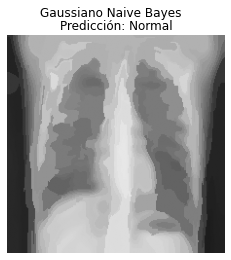

In [0]:
clase2_nbg = nbg.predict(image2_reshape)
print('Imagen con filtro gaussiano')
if clase2_nbg==[0]:
  plt.title('Predicción: Normal')
else:
  plt.title('Predicción: COVID-19')
plt.suptitle('Gaussiano Naive Bayes')
plt.imshow(image2)
plt.axis('off')
plt.show()

Máquina de soporte vectorial

(-0.5, 223.5, 223.5, -0.5)

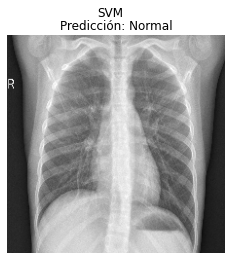

In [0]:
clase2_svm = svm.predict(img2_reshape)
print('Imagen Normal')
if clase2_svm==[0]:
  plt.title('Predicción: Normal')
else:
  plt.title('Predicción: COVID-19')
plt.suptitle('SVM')
plt.imshow(img2)
plt.axis('off')
plt.show()

Imagen con filtro gaussiano y superpixeles


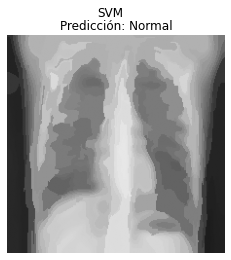

In [0]:
clase2_svm = svm.predict(image2_reshape)
print('Imagen con filtro gaussiano y superpixeles')
if clase2_svm==[0]:
  plt.title('Predicción: Normal')
else:
  plt.title('Predicción: COVID-19')
plt.suptitle('SVM')
plt.imshow(image2)
plt.axis('off')
plt.show()